## 기본 라이브러리 and setting

In [1]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraModel, BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
tf.random.set_seed(111)
np.random.seed(111)

BATCH_SIZE = 4
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_SEQUENCE_LEN = 512

## Data Load

In [3]:
data_df = pd.read_csv("../Data_Preprocessing/data/fine_tuning_data/twoSentencesData.csv", index_col=0)
data_df.columns = ['first_sentence', 'second_sentence', 'label']
data_df.head()

,first_sentence,second_sentence,label
0,새로운 도전을 위해 대학 시절 OO 유학을 떠나게 되었습니다.,조금 늦은 나이의 도전이라 부족한 영어 실력으로 많은 어려움에 부딪쳤습니다.,1
1,조금 늦은 나이의 도전이라 부족한 영어 실력으로 많은 어려움에 부딪쳤습니다.,잠깐 좌절도 했지만 그보다 가장 힘들었던 것은 부모님이 주신 소중한 기회를 제대로 ...,1
2,잠깐 좌절도 했지만 그보다 가장 힘들었던 것은 부모님이 주신 소중한 기회를 제대로 ...,저는 좌절보다는 노력을 택하였습니다.,1
3,저는 좌절보다는 노력을 택하였습니다.,매주 영어 학원과 스터디그룹에 참석하였으며 다양한 이들과의 대화를 위해 혼자 펍에 ...,1
4,매주 영어 학원과 스터디그룹에 참석하였으며 다양한 이들과의 대화를 위해 혼자 펍에 ...,이러한 경험을 바탕으로 경동나비엔의 일원이 되어서도 어떠한 어려움 속에서도 좌절하지...,1


In [4]:
sentencePair = []
labels = np.asarray(data_df['label'].tolist(), dtype=np.int32)

for i in range(len(data_df)):
    temp_df = data_df.iloc[i]
    sentencePair.append([temp_df['first_sentence'], temp_df['second_sentence']])
    
len(sentencePair)

386581

## BertTokenizer

In [5]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

encoded_dict = tokenizer(sentencePair,
                         padding=True,
                         truncation=True,
                         max_length=512,
                         return_tensors='tf')

In [6]:
inputs = (encoded_dict['input_ids'], encoded_dict['attention_mask'], encoded_dict['token_type_ids'])

## Create Model

In [7]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFElectraModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                               kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                               name='classifier')
    
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        # BERT모델 적용
        outputs = self.bert(inputs)
        
        # BERT결과 값으로 Fine tuning하기 위한 벡터로 변환
        pooled_output = outputs.last_hidden_state # [batch_size, sequence_length, hidden]
        pooled_output = pooled_output[:, 0, :]    # take <s> token (equiv. to [CLS]) [batch_size, hidden]
        
        # Fine tuning
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits

cls_model = TFBertClassifier(model_name='monologg/koelectra-base-v3-discriminator',
                            dir_path='bert_ckpt',
                            num_class=2)

Some layers from the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [8]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
model_name = 'tf2_bert_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join('./', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} Directory already exists\n",format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} Directory create complete\n",format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(inputs, labels,
                       epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                       callbacks=[es_callback, cp_callback])

{} Directory already exists
 ./tf2_bert_naver_movie
Epoch 1/3
  112/77316 [..............................] - ETA: 6:32:22 - loss: 0.1418 - accuracy: 0.9442

KeyboardInterrupt: 

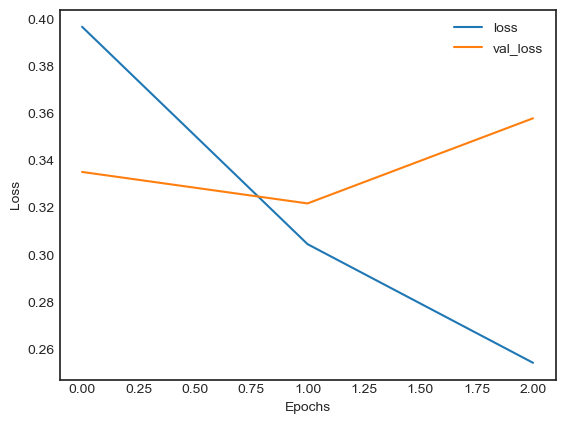

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test_data['document'], test_data['label'])):
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)
    
    try:
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        pass
    
test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_token_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_token_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

49997it [00:10, 4676.67it/s]


In [15]:
cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)

49/49 [==============================] - 114s 2s/step - loss: 0.3628 - accuracy: 0.8485


[0.3628406524658203, 0.8484508991241455]